<a href="https://colab.research.google.com/github/knoppin1/DATA-690-WANG/blob/master/Individual_Project/covid_daily_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 Daily Report
### Ken Noppinger

Source from Gitbhub for Johns Hopkins Resource Center: 

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-11-2020.csv

In [10]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-11-2020.csv

--2020-10-12 19:41:42--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-11-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553112 (540K) [text/plain]
Saving to: ‘10-11-2020.csv’

10-11-2020.csv      100%[===================>] 540.15K  --.-KB/s    in 0.09s   

2020-10-12 19:41:42 (6.01 MB/s) - ‘10-11-2020.csv’ saved [553112/553112]



In [82]:
# Issue with pandas profiling
# Upgrade both packages solve the problem

!pip install  pandas pandas_profiling --upgrade

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.3)
Requirement already up-to-date: pandas_profiling in /usr/local/lib/python3.6/dist-packages (2.9.0)


In [11]:
import pandas as pd
from pandas_profiling import ProfileReport

In [12]:
print(pd.__version__)

1.1.3


In [13]:
df = pd.read_csv("10-11-2020.csv")
df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-10-12 04:23:45,33.93911,67.709953,39799,1477,33114,5208.0,Afghanistan,102.236568,3.711149
1,NaN,NaN,NaN,Albania,2020-10-12 04:23:45,41.15330,20.168300,15399,420,9500,5479.0,Albania,535.096254,2.727450
2,NaN,NaN,NaN,Algeria,2020-10-12 04:23:45,28.03390,1.659600,53072,1801,37170,14101.0,Algeria,121.027908,3.393503
3,NaN,NaN,NaN,Andorra,2020-10-12 04:23:45,42.50630,1.521800,2696,55,1814,827.0,Andorra,3489.290105,2.040059
4,NaN,NaN,NaN,Angola,2020-10-12 04:23:45,-11.20270,17.873900,6366,218,2743,3405.0,Angola,19.369403,3.424442


In [14]:
df.shape

(3955, 14)

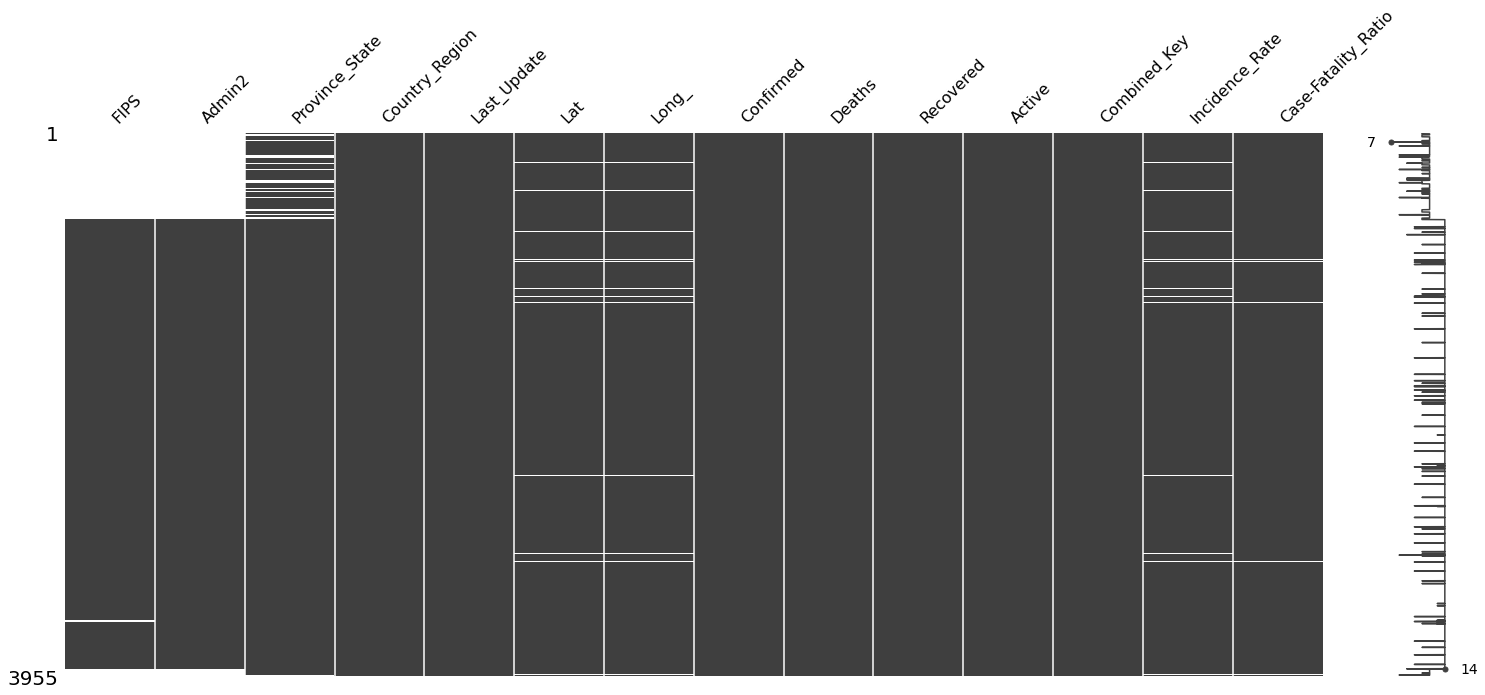

In [79]:
# Reference: https://analyticsindiamag.com/tutorial-on-missingno-python-tool-to-visualize-missing-values/
import missingno as msno
msno.matrix(df)

In [21]:
df1 = df[df.FIPS.notna()]
df1.shape

(3259, 14)

In [24]:
df2 = df[df.Country_Region == "US"]
df2.shape

(3270, 14)

In [27]:
df3 = df2[df2.FIPS.isna()]
df3.shape

(11, 14)

In [28]:
df3

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
1878,NaN,Dukes and Nantucket,Massachusetts,US,2020-10-12 04:23:45,41.406747,-70.687635,200,2,0,198.0,"Dukes and Nantucket, Massachusetts, US",696.112213,1.000000
1913,NaN,Federal Correctional Institution (FCI),Michigan,US,2020-10-12 04:23:45,NaN,NaN,195,5,0,190.0,"Federal Correctional Institution (FCI), Michig...",NaN,2.564103
1945,NaN,Michigan Department of Corrections (MDOC),Michigan,US,2020-10-12 04:23:45,NaN,NaN,5650,75,0,5575.0,"Michigan Department of Corrections (MDOC), Mic...",NaN,1.327434
2198,NaN,Kansas City,Missouri,US,2020-10-12 04:23:45,39.099700,-94.578600,13077,168,0,12909.0,"Kansas City, Missouri, US",2674.544886,1.284698
3072,NaN,NaN,Recovered,US,2020-10-12 04:23:45,NaN,NaN,0,0,3075077,-3075077.0,"Recovered, US",NaN,NaN
3545,NaN,Bear River,Utah,US,2020-10-12 04:23:45,41.521068,-113.083282,4038,12,0,4026.0,"Bear River, Utah, US",2161.461958,0.297177
3546,NaN,Central Utah,Utah,US,2020-10-12 04:23:45,39.372319,-111.575868,880,5,0,875.0,"Central Utah, Utah, US",1073.773092,0.568182
3550,NaN,Southeast Utah,Utah,US,2020-10-12 04:23:45,38.996171,-110.701396,289,2,0,287.0,"Southeast Utah, Utah, US",718.387233,0.692042
3551,NaN,Southwest Utah,Utah,US,2020-10-12 04:23:45,37.854472,-111.441876,4873,42,0,4831.0,"Southwest Utah, Utah, US",1933.407924,0.861892
3554,NaN,TriCounty,Utah,US,2020-10-12 04:23:45,40.124915,-109.517442,287,2,0,285.0,"TriCounty, Utah, US",506.870121,0.696864


In [44]:
df4 = df2[df2.FIPS.notna()]
df4.shape

(3259, 14)

In [50]:
df4[df4.Admin2 == "Unassigned"] # If County is unassigned, then stats have no meaning in the study

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
696,90001.0,Unassigned,Alabama,US,2020-10-12 04:23:45,NaN,NaN,0,0,0,0.0,"Unassigned, Alabama, US",NaN,NaN
723,90002.0,Unassigned,Alaska,US,2020-10-12 04:23:45,NaN,NaN,22,0,0,22.0,"Unassigned, Alaska, US",NaN,0.000000
741,90004.0,Unassigned,Arizona,US,2020-10-12 04:23:45,NaN,NaN,0,1,0,NaN,"Unassigned, Arizona, US",NaN,NaN
813,90005.0,Unassigned,Arkansas,US,2020-10-12 04:23:45,NaN,NaN,1968,0,0,1968.0,"Unassigned, Arkansas, US",NaN,0.000000
875,90006.0,Unassigned,California,US,2020-10-12 04:23:45,NaN,NaN,0,0,0,0.0,"Unassigned, California, US",NaN,NaN
941,90008.0,Unassigned,Colorado,US,2020-10-12 04:23:45,NaN,NaN,0,0,0,0.0,"Unassigned, Colorado, US",NaN,NaN
952,90009.0,Unassigned,Connecticut,US,2020-10-12 04:23:45,NaN,NaN,123,0,0,123.0,"Unassigned, Connecticut, US",NaN,0.000000
957,90010.0,Unassigned,Delaware,US,2020-10-12 04:23:45,NaN,NaN,91,0,0,91.0,"Unassigned, Delaware, US",NaN,0.000000
1022,90012.0,Unassigned,Florida,US,2020-10-12 04:23:45,NaN,NaN,1882,0,0,1882.0,"Unassigned, Florida, US",NaN,0.000000
1172,90013.0,Unassigned,Georgia,US,2020-10-12 04:23:45,NaN,NaN,2077,4,0,2073.0,"Unassigned, Georgia, US",NaN,0.192585


In [51]:
df5 = df4[df4.Admin2 != "Unassigned"]
df5.shape

(3208, 14)

## Clean up columns

In [54]:
df5.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')

In [80]:
irrelevant_columns = ['Country_Region','Last_Update', 'Lat', 'Long_', 'Recovered', 'Active']
df6 = df5.drop(irrelevant_columns, axis=1)
df6.rename(columns = {'Admin2':'County'}, inplace = True)
df6

,FIPS,County,Province_State,Confirmed,Deaths,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
632,1001.0,Autauga,Alabama,1905,28,"Autauga, Alabama, US",3409.762122,1.469816
633,1003.0,Baldwin,Alabama,6203,65,"Baldwin, Alabama, US",2778.698585,1.047880
634,1005.0,Barbour,Alabama,942,9,"Barbour, Alabama, US",3815.928056,0.955414
635,1007.0,Bibb,Alabama,736,12,"Bibb, Alabama, US",3286.594624,1.630435
636,1009.0,Blount,Alabama,1713,16,"Blount, Alabama, US",2962.335282,0.934034
...,...,...,...,...,...,...,...,...
3896,56037.0,Sweetwater,Wyoming,394,2,"Sweetwater, Wyoming, US",930.496186,0.507614
3897,56039.0,Teton,Wyoming,662,1,"Teton, Wyoming, US",2821.343334,0.151057
3898,56041.0,Uinta,Wyoming,380,2,"Uinta, Wyoming, US",1878.769900,0.526316
3900,56043.0,Washakie,Wyoming,125,6,"Washakie, Wyoming, US",1601.537476,4.800000


In [81]:
df6.dtypes

FIPS                   float64
County                  object
Province_State          object
Confirmed                int64
Deaths                   int64
Combined_Key            object
Incidence_Rate         float64
Case-Fatality_Ratio    float64
dtype: object

In [70]:
df6["FIPS"] = df6.FIPS.astype(int)
df6.FIPS.dtypes

dtype('int64')

In [71]:
df6.head()

,FIPS,County,Province_State,Confirmed,Deaths,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
632,1001,Autauga,Alabama,1905,28,"Autauga, Alabama, US",3409.762122,1.469816
633,1003,Baldwin,Alabama,6203,65,"Baldwin, Alabama, US",2778.698585,1.047880
634,1005,Barbour,Alabama,942,9,"Barbour, Alabama, US",3815.928056,0.955414
635,1007,Bibb,Alabama,736,12,"Bibb, Alabama, US",3286.594624,1.630435
636,1009,Blount,Alabama,1713,16,"Blount, Alabama, US",2962.335282,0.934034


In [76]:
df6.Province_State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Diamond Princess',
       'District of Columbia', 'Florida', 'Georgia', 'Grand Princess',
       'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota',
       'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [77]:
# of  Provinces/States in study
len(df6.Province_State.unique())

57

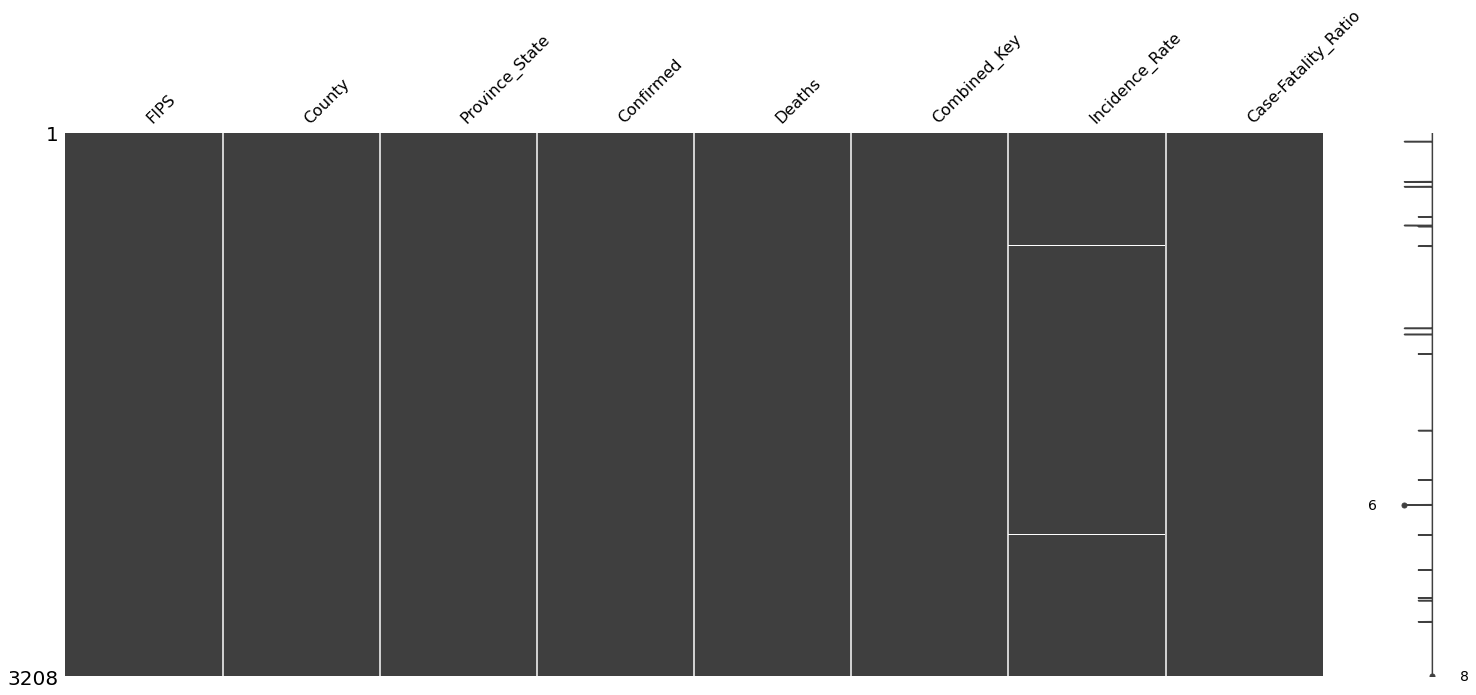

In [78]:
# Reference: https://analyticsindiamag.com/tutorial-on-missingno-python-tool-to-visualize-missing-values/
import missingno as msno
msno.matrix(df6)

## Pandas Profile Report

In [52]:
type(df)

pandas.core.frame.DataFrame

In [83]:
prof = ProfileReport(df6, minimal=True)
prof.to_file(output_file="covid19_daily_report.html")
prof

## Next

In [ ]:
state_density_URL = "https://worldpopulationreview.com/f1a1161f-dd0a-4d8c-9fca-e00f2da5f7bf"
!wget https://worldpopulationreview.com/f1a1161f-dd0a-4d8c-9fca-e00f2da5f7bf